# Benchmark for Maxwell-Faraday Equations


Constituitive equations: 
$\partial_tB = -\star dE  \\
\partial_tE = \frac{\star^{-1} dB}{\mu_0 \epsilon_0} $


where
E = electric field (1-form)
B = magnetic field (2-form)
$\mu_0$ = permeability of free space = $1.2566e^{-6} m kg s^{-2} A^{-2}$
$\epsilon_0$ = permittivity of free space = $8.8542e^{-12} m^{-3} kg^{-1} s^4 A^2$

In [1]:
using CombinatorialSpaces, DifferentialEquations, CairoMakie
using MeshIO
using CombinatorialSpaces.DiscreteExteriorCalculus: inv_hodge_star
using CombinatorialSpaces.SimplicialSets: d

# dual subdivision 
function dual(s::EmbeddedDeltaSet2D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex2D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Circumcenter())
  sd
end

dual (generic function with 1 method)

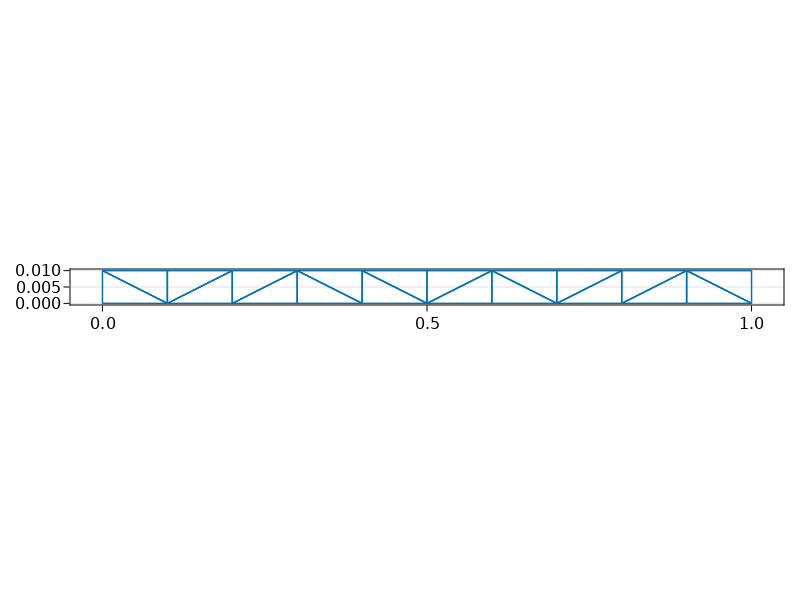

In [2]:
# Define mesh
s = EmbeddedDeltaSet2D("meshes/wire.obj")
sd = dual(s);

# Plot mesh
fig, ax, ob = wireframe(s)
ax.aspect = AxisAspect(20/1)
fig

## Add the physics (static E-field)

In [ ]:
# Initial conditions
x = [p[1] for p in s[:point]];

# Initial straight 1-form electric field
eField(x) = begin
  amp = sin(3*π*(x[1]))
  amp * Point{3,Float32}(1,0,0)
end

E = ♭(sd, DualVectorField(eField.(sd[triangle_center(sd),:dual_point])))

# Initial straight 2-form magnetic field
B = TriForm(zeros(ntriangles(s)))

u0 = vcat(B.data)

B_range = (1:length(B))



vf(du, u, p, t) = begin
    du[B_range] .= -1 .* d(s, E)
end

# plot(E.data)

## Run the simulation (static E-field)

In [ ]:
tspan = (0.0,10.0)
prob = ODEProblem(vf, u0, tspan);
sol = solve(prob, Tsit5());

if sol.retcode != :Success
    println(sol.retcode)
end

## Add the physics (time-varying E-field)

[-0.0, -0.0009999999970648661, -0.0010000000149011613, -0.0010000000149011613, 0.0, -0.0010000000623275771, -0.0010000000149011613, -0.0010000000149011613, -0.0, -0.001000000089406967, -0.001000000089406967, 0.0, -0.001000000089406967, -0.0009999999403953552, -0.0009999999403953552, -0.0, -0.0009999999403953552, -0.000999999940395355, -0.0009999999403953552, -0.0009999999403953552, 0.0, -0.0010000002265003376, -0.0010000002384185792, -0.0010000002384185792, -0.0, -0.0009999996764279134, -0.0009999996423721313, -0.0009999996423721313, 0.0, -0.001000000229904858, -0.0010000002384185792, -0.0010000002384185792, -0.0, -0.0009999996423721313, -0.0009999996423721313, 0.0, -0.0009999996423721313, -0.0010000002384185792, -0.0010000002243944633, -0.0, -0.0010000002384185792]

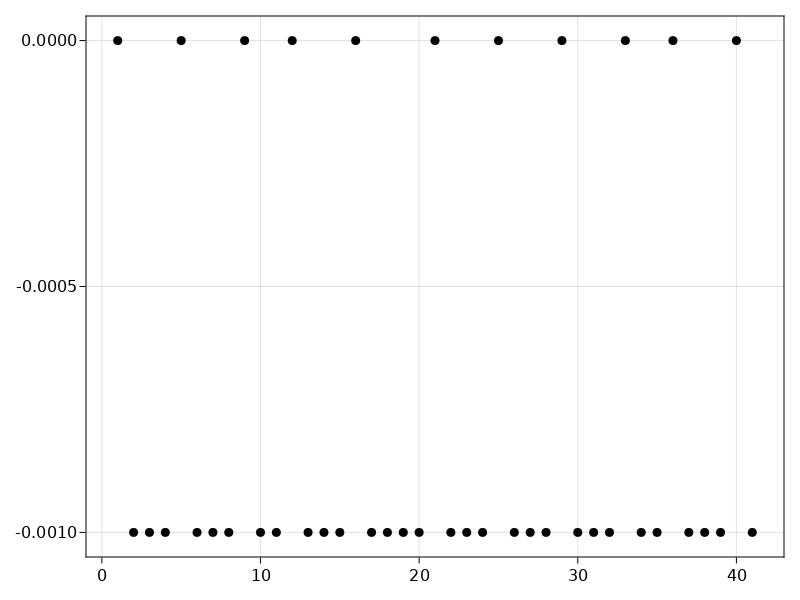

In [15]:
# Constants
μ = 1.2566
ϵ = 8.8542

# Initial conditions
x = [p[1] for p in s[:point]];

# Initial straight 1-form electric field
eField(x) = begin
    amp = 0.01
#   amp = sin(6*π*(x[2]))
    amp * Point{3,Float32}(1,0,0)
end

E = ♭(sd, DualVectorField(eField.(sd[triangle_center(sd),:dual_point])))

# Initial straight 2-form magnetic field
B = TriForm(zeros(ntriangles(s)))

print(E.data)
u0 = vcat(E.data, B.data)

E_range = 1:length(E)
B_range = (1:length(B)) .+ length(E)



vf(du, u, p, t) = begin
    du[B_range] .= -1 .* ⋆(Val{2}, sd, d(Val{1}, sd, u[E_range]))
    du[E_range] .= inv_hodge_star(Val{1}, sd, dual_derivative(Val{0}, 
            sd, (u[B_range]./(p[1]*p[2]))))
    @show(u[E_range])
#     @show(du[B_range]) 
#     @show(du[E_range])
end

plot(E.data)

## Run the simulation (time-varying E-field)

In [16]:
tspan = (0.0,5.0)
prob = ODEProblem(vf, u0, [μ,ϵ], tspan);
sol = solve(prob, Tsit5());

if sol.retcode != :Success
    println(sol.retcode)
end

u[E_range] = [-0.0, -0.0009999999970648661, -0.0010000000149011613, -0.0010000000149011613, 0.0, -0.0010000000623275771, -0.0010000000149011613, -0.0010000000149011613, -0.0, -0.001000000089406967, -0.001000000089406967, 0.0, -0.001000000089406967, -0.0009999999403953552, -0.0009999999403953552, -0.0, -0.0009999999403953552, -0.000999999940395355, -0.0009999999403953552, -0.0009999999403953552, 0.0, -0.0010000002265003376, -0.0010000002384185792, -0.0010000002384185792, -0.0, -0.0009999996764279134, -0.0009999996423721313, -0.0009999996423721313, 0.0, -0.001000000229904858, -0.0010000002384185792, -0.0010000002384185792, -0.0, -0.0009999996423721313, -0.0009999996423721313, 0.0, -0.0009999996423721313, -0.0010000002384185792, -0.0010000002243944633, -0.0, -0.0010000002384185792]
u[E_range] = [-0.0, -0.0009999999970648661, -0.0010000000149011613, -0.0010000000149011613, 0.0, -0.0010000000623275771, -0.0010000000149011613, -0.0010000000149011613, -0.0, -0.001000000089406967, -0.001000000

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\mgatlin3\.julia\packages\OrdinaryDiffEq\PZbGY\src\initdt.jl:108
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\mgatlin3\.julia\packages\OrdinaryDiffEq\PZbGY\src\solve.jl:510
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase C:\Users\mgatlin3\.julia\packages\SciMLBase\UIp7W\src\integrator_interface.jl:325


## Plot results

In [ ]:
t = 1
sd2 = deepcopy(sd)
new_points = [Point3{Float32}(p[1],0,sol(t)[B_range[i]]) for (i,p) in enumerate(sd[triangle_center(sd),:dual_point])] 
sd2[triangle_center(sd2),:dual_point] .= new_points

limits = FRect3D(Vec3f0(-1.0, -1.0, -1.0), Vec3f0(1.5,0.5,0.6))
fig, ax, ob = wireframe(sd2, limits=limits)

## Record results (3D)

In [ ]:
tn = Node(0.0)
sd2 = deepcopy(sd)
f(t) = begin
    new_points = [Point3{Float32}(p[1],0,sol(t)[B_range[i]]) for (i,p) in enumerate(sd[triangle_center(sd),:dual_point])] 
    sd2[triangle_center(sd2),:dual_point] .= new_points
    sd2
end

limits = FRect3D(Vec3f0(-1.0, -1.0, -1.0), Vec3f0(1.5,0.5,0.6))
fig, ax, ob = wireframe(lift(t->f(t), tn); limits=limits)
i_range = range(0,10.0, length=100)
framerate = 30
record(fig, "EM_3D.gif", i_range; framerate = framerate) do i
  tn[] = i
end